In [1]:
stn = '215'
start_date = "10/01/2020 02:00" # MM/DD/YYYY HH:MM
dataset = 'archive' # Enter 'archive' or 'realtime'

In [4]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar

In [5]:
# CDIP THREDDS OPeNDAP Dataset URL
# Archive
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/' + stn + 'p1/' + stn + 'p1_historic.nc'
# Realtime 
if dataset == 'realtime':
    data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/' + stn + 'p1_rt.nc'

In [6]:
nc = netCDF4.Dataset(data_url)

In [7]:
waveTime = nc.variables['waveTime'][:]
Dmean = nc.variables['waveMeanDirection']
Fq = nc.variables['waveFrequency'] 
Ed = nc.variables['waveEnergyDensity']

In [8]:
station_name = nc.variables['metaStationName'][:]
station_title = station_name.tobytes().decode().split('\x00',1)[0]

In [9]:
# Find nearest value in numpy array
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Convert to unix timestamp
def get_unix_timestamp(humanTime,dateFormat):
    unix_timestamp = int(calendar.timegm(datetime.datetime.strptime(humanTime, dateFormat).timetuple()))
    return unix_timestamp

# Convert to human readable timestamp
def get_human_timestamp(unix_timestamp, dateFormat):
    human_timestamp = datetime.datetime.utcfromtimestamp(int(unix_timestamp)).strftime(dateFormat)
    return human_timestamp

In [10]:
unix_start = get_unix_timestamp(start_date, '%m/%d/%Y %H:%M') 
nearest_start = find_nearest(waveTime, unix_start)  # Find the closest unix timestamp
nearest_index = np.where(waveTime==nearest_start)[0][0]  # Grab the index number of found date

print('Requsted: ' + get_human_timestamp(unix_start, '%m/%d/%Y %H:%M:%S'))
print(' Nearest: ' + get_human_timestamp(nearest_start, '%m/%d/%Y %H:%M:%S'))

print(start_date)
print(unix_start)

Requsted: 10/01/2020 02:00:00
 Nearest: 10/01/2020 02:00:00
10/01/2020 02:00
1601517600


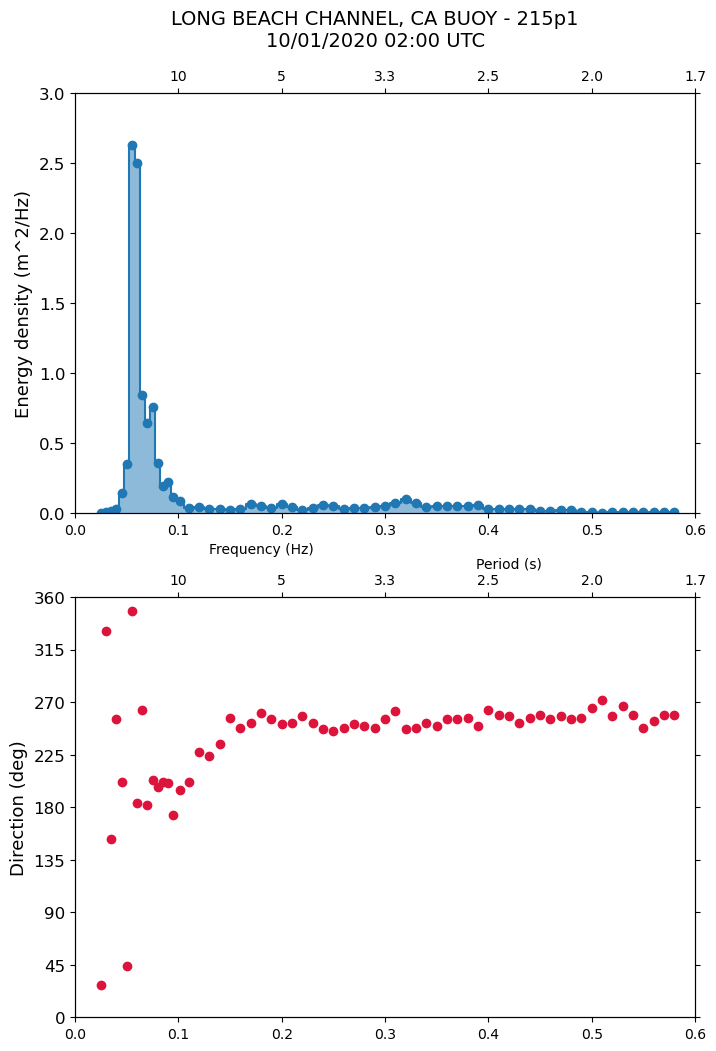

In [12]:
# Create figure and specify figure size
fig = plt.figure(figsize=(8, 12))

# Create 2 stacked subplots for Energy Density (Ed) and Mean Direction (Dmean)
pEd = plt.subplot(2, 1, 1)
pEd.step(Fq[:], Ed[nearest_index, :], marker='o', where='mid')
pEd.fill_between(Fq[:], Ed[nearest_index, :], alpha=0.5, step="mid")
pDmean = plt.subplot(2, 1, 2, sharex=pEd)
pDmean.plot(Fq[:], Dmean[nearest_index, :], color='crimson', marker='o', linestyle="")

# Set title
plt.suptitle(station_title + '\n' + get_human_timestamp(nearest_start, '%m/%d/%Y %H:%M') + ' UTC' , fontsize=14, y=0.95)

# Set tick parameters
pEd.tick_params(axis='y', which = 'major', labelsize=12, right='off')
pDmean.tick_params(axis='y', which = 'major', labelsize=12, right='off')

# Make secondary x- and y-axes for each graph. Shows both Frequency and Period for x-axes.
pEd2y = pEd.twiny() # Copy x-axis for Graph #1
pDmean2y = pDmean.twiny() # Copy x-axis for Graph #2

# Set axis limits for each plot
ymax = np.ceil(max(Ed[nearest_index, :]))
pEd.set_xlim(0, 0.6)
pEd.set_ylim(0, ymax)
pEd2y.set_xlim(0, 0.6)
pDmean.set_ylim(0, 360)
pDmean.set_yticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
pDmean2y.set_xlim(0, 0.6)

# Label each axis
pEd.set_xlabel('Frequency (Hz)', fontsize = 10, x = 0.3)
pEd.set_ylabel('Energy density (m^2/Hz)', fontsize = 13)
pDmean.set_ylabel('Direction (deg)', fontsize = 13)
pDmean2y.set_xlabel('Period (s)', fontsize = 10, x = 0.7)

## Format top axis labels to show 'Period' values at tickmarks corresponding to 'Frequency' x-axs
# Top subplot
pEd2y.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
pEd2y.set_xticklabels(['10', '5', '3.3', '2.5', '2.0', '1.7'])

# Bottom subplot
pDmean2y.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
pDmean2y.set_xticklabels(['10', '5', '3.3', '2.5', '2.0', '1.7'])
plt.savefig('cdip_web.png')

# Plot dashed gridlines
#pEd.grid(b=True, which='major', axis='x', alpha=0.3, linestyle='-')
#pEd.grid(b=True, which='major', axis='y', alpha=0.3, linestyle='-')
#pDmean.grid(b=True, which='major', axis='x', alpha=0.3, linestyle='-')
#pDmean.grid(b=True, which='major', axis='y', alpha=0.3, linestyle='-')

In [56]:
freqs = Fq[:]
amps = Ed[nearest_index, :]
direcs = Dmean[nearest_index, :]

In [57]:
import os

folder_path = "C:\\Users\\berna\\OneDrive\Desktop\\my_run_FUNWAVE\\READ_PREPARE_SPECTRUM"

frequencies = freqs.data
amplitudes = amps.data
directions = direcs.data

file_name = "CDIP_extracted_freqs.txt"
file_path = os.path.join(folder_path, file_name)
np.savetxt(file_path, frequencies)

file_name = "CDIP_extracted_amps.txt"
file_path = os.path.join(folder_path, file_name)
np.savetxt(file_path, amplitudes)

file_name = "CDIP_extracted_direcs.txt"
file_path = os.path.join(folder_path, file_name)
np.savetxt(file_path, directions)